# Forecasting
In this notebook, we shall use the modelling techniques we learned about in the concepts notebook and apply that information to forecast or predict future values of a time series.

## Content
- Load Data
- ARIMA manual
- SARIMAX
- Auto ARIMA
- Auto ARIMA with seasonality
- Prophet
- Seasonality Decomposition and trend prediction

In [1]:
# Import dependencies

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

## Load data
For continuity, we are going to use the same data that we used in the concepts notebook. Scale it down to 30 min samples because training takes a long time otherwise.

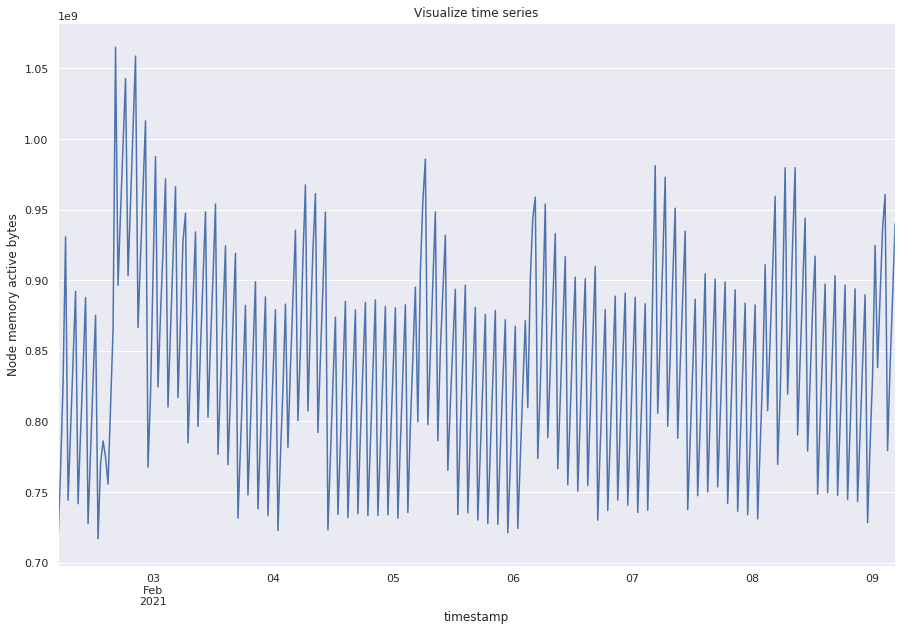

In [2]:
metric_df = pd.read_pickle("../data/raw/ts.pkl")
### 30 mins because it gets very difficult to model otherwise
ts = metric_df["value"].astype(float).resample("30min").mean()
sns.set()
ts.plot(figsize=(15, 10))
plt.title("Visualize time series")
plt.ylabel("Node memory active bytes")
plt.show()

In [3]:
# Divide into train and test set
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

# Define helper dates
first_date = train.index[0]
sample_date = pd.to_datetime("2021-02-06", utc=True)
start_date = pd.to_datetime("2021-02-08", utc=True)
end_date = pd.to_datetime("2021-02-09", utc=True)

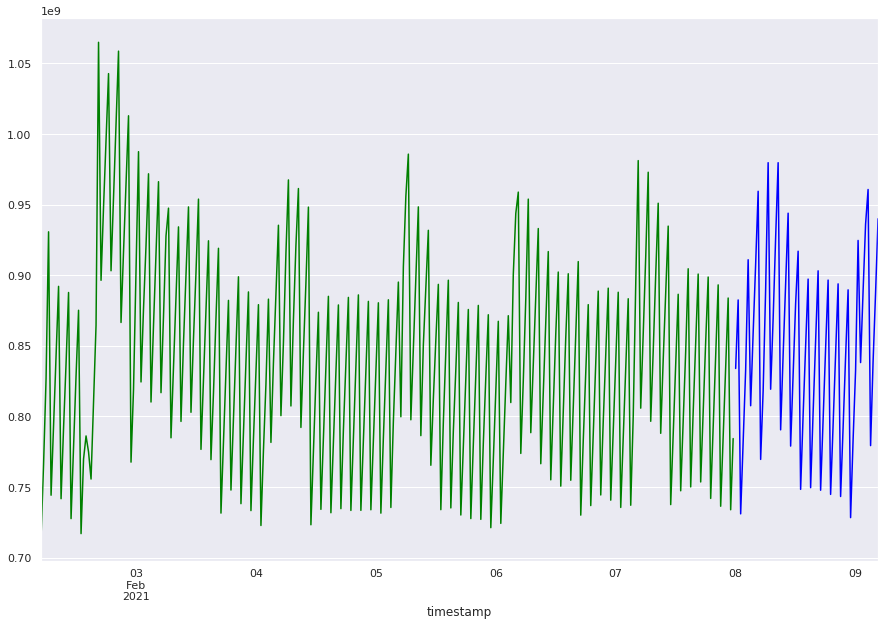

In [4]:
# Plot train and test sets
train.plot(figsize=(15, 10), color="green")
test.plot(figsize=(15, 10), color="blue")

In [5]:
def plot_predicts_aam(pred_train, pred):
    """
    Plots train, test, prediction of training set, and prediction of test set
    for auto arima and fbprophet
    """
    train.plot(figsize=(15, 10), color="green", label="Train actual")

    pd.Series(pred_train, index=train[:start_date].index).plot(
        figsize=(15, 10), color="red", label="Train prediction"
    )

    test.plot(figsize=(15, 10), color="blue", label="Test actual")

    pd.Series(pred, index=test[start_date:].index).plot(
        figsize=(15, 10), color="orange", label="Test prediction"
    )
    plt.legend()
    plt.show()


def plot_predicts_man(pred_train, pred):
    """
    Plots train, test, prediction of training set, and prediction of test set
    for manual ARIMA
    """
    train.plot(figsize=(15, 10), color="green", label="Train actual")

    pred_train.plot(figsize=(15, 10), color="red", label="Train prediction")

    test.plot(figsize=(15, 10), color="blue", label="Test actual")

    pred.plot(figsize=(15, 10), color="orange", label="Test prediction")
    plt.legend()
    plt.show()

## Auto Arima 

In [6]:
aam_default = auto_arima(train)
pred_aam_default = aam_default.predict(n_periods=len(test))
pred_train_aam_default = aam_default.predict(n_periods=len(train[:start_date]))

In [7]:
aam_default.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  278
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -5418.948
Date:                Tue, 06 Apr 2021   AIC                          10843.896
Time:                        22:27:24   BIC                          10854.779
Sample:                             0   HQIC                         10848.263
                                - 278                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     8.4e+08   6.11e-10   1.38e+18      0.000     8.4e+08     8.4e+08
ma.L1          0.2307      0.067      3.427      0.001       0.099       0.363
sigma2      5.066e+15   1.05e-19   4.82e+34      0.000    5.07e+15    5.07e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.95   Prob(JB):                         0.37
Heteroskedasticity (H):               0.68   Skew:                            -0.05
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.47e+51. Standard errors may be unstable.
"""

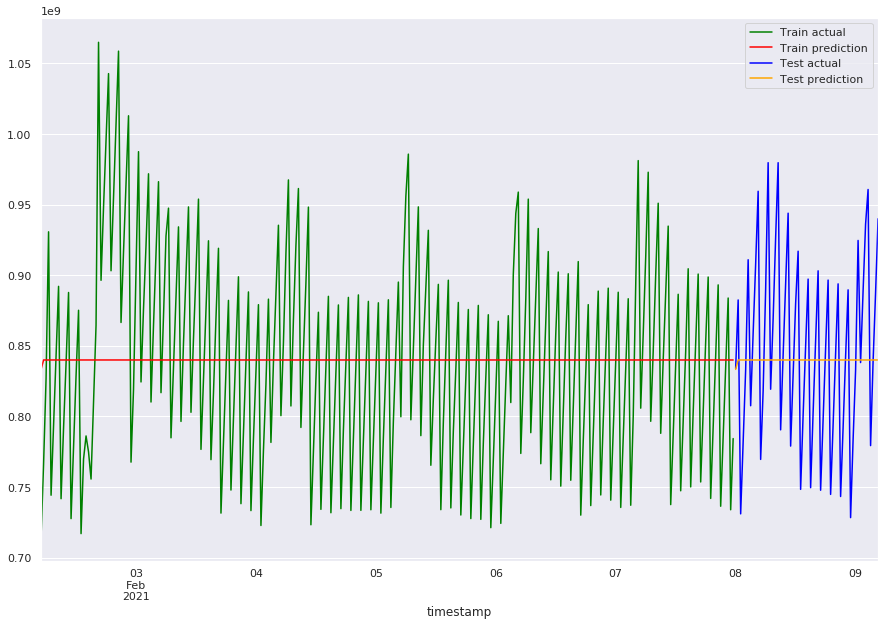

In [8]:
plot_predicts_aam(pred_train_aam_default, pred_aam_default)

In [9]:
mae_train_aam_default = mean_absolute_error(pred_train_aam_default, train)
mae_aam_default = mean_absolute_error(pred_aam_default, test)
print(f"train error: {mae_train_aam_default}, test error: {mae_aam_default}")

train error: 59704447.00298849, test error: 55499026.40818263


### Auto arima with seasonality and trend 

In [10]:
aam_tuned = auto_arima(
    train,
    #            exogenous=,
    m=4,  # SARIMAX s
    max_order=None,
    max_p=5,  # Search till p=6
    max_q=5,  # Search till q=6
    max_d=2,  # Search till d=2
    max_P=4,  # Search till P=2
    max_Q=4,  # Search till Q=2
    max_D=2,  # Search till D=2
    maxiter=30,  # Increase if you see no convergence
    njobs=7,  # Number of parallel processes
    trend="ct",  ##ctt for quadratic; accounts for trend in data
    information_criterion="aic",  # out of bag aic, aicc, bic, hqic
    # out_of_sample_size=int(len(ts) * 0.2),  ## Validation set of 20% for oob
)

In [11]:
aam_tuned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                  278
Model:             SARIMAX(3, 0, 2)x(0, 0, [1, 2, 3], 4)   Log Likelihood               -5295.031
Date:                                   Tue, 06 Apr 2021   AIC                          10612.062
Time:                                           22:28:27   BIC                          10651.966
Sample:                                                0   HQIC                         10628.071
                                                   - 278                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.802e+08    378.075   2.06e+06      0.000     7.8e+08     7.8e+08
drift      -1.389e+05    5.9e+05     -0.235      0.814    -1.3e+06    1.02e+06
ar.L1          0.5139      0.142      3.628      0.000       0.236       0.792
ar.L2         -0.9205      0.177     -5.200      0.000      -1.267      -0.574
ar.L3          0.5036      0.124      4.051      0.000       0.260       0.747
ma.L1          0.1562      0.222      0.702      0.482      -0.280       0.592
ma.L2          0.9495      0.262      3.628      0.000       0.437       1.462
ma.S.L4        0.6971      0.268      2.605      0.009       0.173       1.221
ma.S.L8        0.6389      0.342      1.871      0.061      -0.030       1.308
ma.S.L12       0.3947      0.252      1.565      0.118      -0.100       0.889
sigma2      4.393e+15   1.78e-06   2.46e+21      0.000    4.39e+15    4.39e+15
===================================================================================
Ljung-Box (L1) (Q):                   3.20   Jarque-Bera (JB):              1005.96
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.15e+44. Standard errors may be unstable.
"""

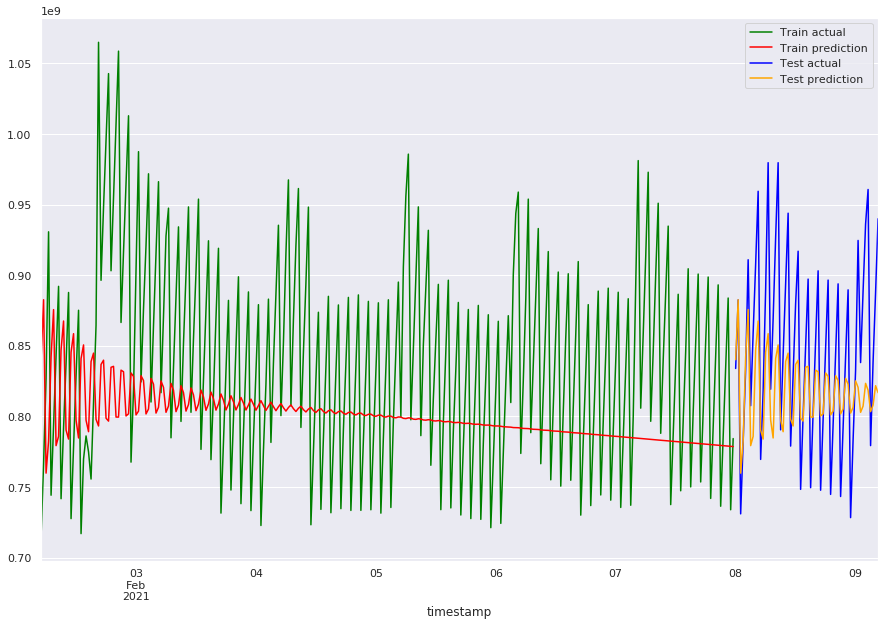

In [12]:
pred_aam_tuned = aam_tuned.predict(n_periods=len(test))
pred_train_aam_tuned = aam_tuned.predict(n_periods=len(train[:start_date]))
plot_predicts_aam(pred_train_aam_tuned, pred_aam_tuned)

In [13]:
mae_train_aam_tuned = mean_absolute_error(pred_train_aam_tuned, train)
mae_aam_tuned = mean_absolute_error(pred_aam_tuned, test)
print(f"train error: {mae_train_aam_tuned}, test error: {mae_aam_tuned}")

train error: 69104681.4315166, test error: 48501662.87943022


### ARIMA manual

In [14]:
first_date = train.index[1]
end_date = test.index[-1]

In [15]:
arima_312 = ARIMA(train, order=(3, 1, 2)).fit()
pred_arima_312 = arima_312.predict(start=start_date, end=end_date)
pred_train_arima_312 = arima_312.predict(start=first_date, end=start_date)
arima_312.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  277
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5126.479
Method:                       css-mle   S.D. of innovations       25828119.266
Date:                Tue, 06 Apr 2021   AIC                          10266.958
Time:                        22:28:28   BIC                          10292.326
Sample:                    02-02-2021   HQIC                         10277.137
                         - 02-07-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.504e+05        nan        nan        nan         nan         nan
ar.L1.D.value    -1.0033        nan        nan        nan         nan         nan
ar.L2.D.value    -0.9420      0.000  -6697.477      0.000      -0.942      -0.942
ar.L3.D.value    -0.9387      0.000  -7245.019      0.000      -0.939      -0.938
ma.L1.D.value     1.0522      0.047     22.469      0.000       0.960       1.144
ma.L2.D.value     0.0563      0.047      1.201      0.230      -0.036       0.148
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2           -0.0017           -1.0321j            1.0321           -0.2503
AR.3           -0.0017           +1.0321j            1.0321            0.2503
MA.1           -1.0044           +0.0000j            1.0044            0.5000
MA.2          -17.6740           +0.0000j           17.6740            0.5000
-----------------------------------------------------------------------------
"""

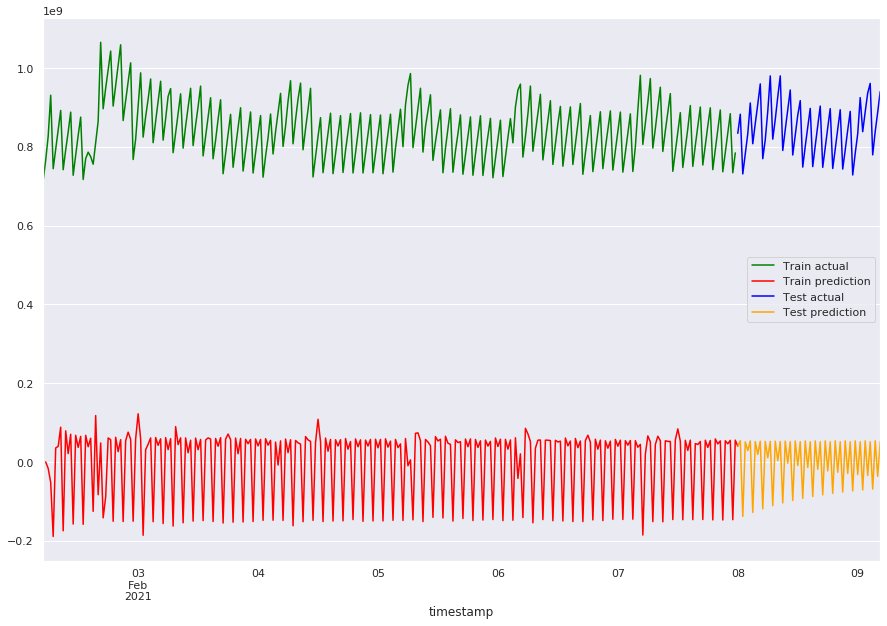

In [16]:
plot_predicts_man(pred_train_arima_312, pred_arima_312)

In [17]:
mae_train_arima_312 = mean_absolute_error(pred_train_arima_312, train)
mae_arima_312 = mean_absolute_error(pred_arima_312, test)
print(f"train error: {mae_train_arima_312}, test error: {mae_arima_312}")

train error: 839811151.3563331, test error: 847309633.8738719


In [18]:
arima_313 = ARIMA(train, order=(3, 1, 3)).fit()
pred_arima_313 = arima_313.predict(start=start_date, end=end_date)
pred_train_arima_313 = arima_313.predict(start=first_date, end=start_date)
arima_313.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  277
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5056.131
Method:                       css-mle   S.D. of innovations       19786859.521
Date:                Tue, 06 Apr 2021   AIC                          10128.263
Time:                        22:28:34   BIC                          10157.255
Sample:                    02-02-2021   HQIC                         10139.895
                         - 02-07-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.504e+05      1.182   2.12e+05      0.000     2.5e+05     2.5e+05
ar.L1.D.value    -1.0004      0.000  -2137.761      0.000      -1.001      -1.000
ar.L2.D.value    -1.0004      0.000  -2138.443      0.000      -1.001      -1.000
ar.L3.D.value    -1.0000        nan        nan        nan         nan         nan
ma.L1.D.value     0.9829      0.008    123.454      0.000       0.967       0.999
ma.L2.D.value     0.9780        nan        nan        nan         nan         nan
ma.L3.D.value     0.9840        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           -0.0000j            1.0000           -0.5000
AR.2           -0.0002           -1.0000j            1.0000           -0.2500
AR.3           -0.0002           +1.0000j            1.0000            0.2500
MA.1           -1.0056           -0.0000j            1.0056           -0.5000
MA.2            0.0058           -1.0053j            1.0053           -0.2491
MA.3            0.0058           +1.0053j            1.0053            0.2491
-----------------------------------------------------------------------------
"""

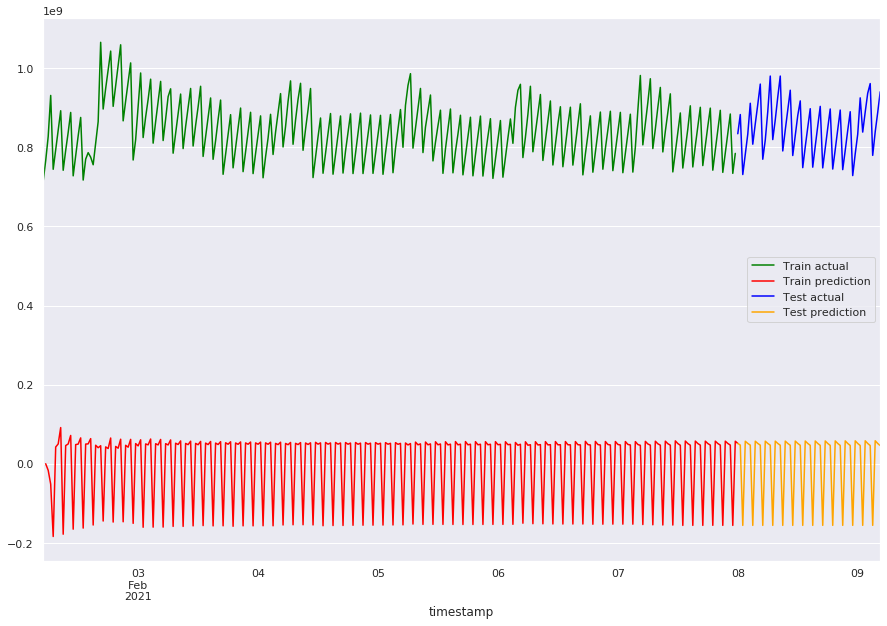

In [19]:
plot_predicts_man(pred_train_arima_313, pred_arima_313)

In [20]:
mae_train_arima_313 = mean_absolute_error(pred_train_arima_313, train)
mae_arima_313 = mean_absolute_error(pred_arima_313, test)
print(f"train error: {mae_train_arima_313}, test error: {mae_arima_313}")

train error: 839955467.486684, test error: 846572065.3563603


In [21]:
### SARIMAX

In [22]:
sarima_3133134 = SARIMAX(
    train, order=(3, 1, 3), seasonal_order=(3, 1, 3, 4)
).fit()
pred_sarima_3133134 = sarima_3133134.predict(start=start_date, end=end_date)
pred_train_sarima_3133134 = sarima_3133134.predict(
    start=first_date, end=start_date
)
sarima_3133134.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  278
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 4)   Log Likelihood               -5041.015
Date:                           Tue, 06 Apr 2021   AIC                          10108.029
Time:                                   22:28:40   BIC                          10154.952
Sample:                               02-02-2021   HQIC                         10126.865
                                    - 02-07-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1141     10.763      0.011      0.992     -20.981      21.209
ar.L2         -0.0459     11.028     -0.004      0.997     -21.661      21.569
ar.L3         -0.0476      8.423     -0.006      0.995     -16.557      16.462
ma.L1         -0.1001     10.746     -0.009      0.993     -21.161      20.961
ma.L2          0.0281     11.041      0.003      0.998     -21.613      21.669
ma.L3          0.0612      8.464      0.007      0.994     -16.527      16.650
ar.S.L4       -0.8363      0.188     -4.452      0.000      -1.205      -0.468
ar.S.L8        0.2501      0.286      0.875      0.381      -0.310       0.810
ar.S.L12       0.5071      0.170      2.978      0.003       0.173       0.841
ma.S.L4        0.5739      0.178      3.226      0.001       0.225       0.923
ma.S.L8       -0.5780      0.174     -3.318      0.001      -0.919      -0.237
ma.S.L12      -0.5949      0.165     -3.605      0.000      -0.918      -0.271
sigma2      8.479e+14   1.93e-12   4.39e+26      0.000    8.48e+14    8.48e+14
===================================================================================
Ljung-Box (L1) (Q):                   4.34   Jarque-Bera (JB):              3002.25
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+42. Standard errors may be unstable.
"""

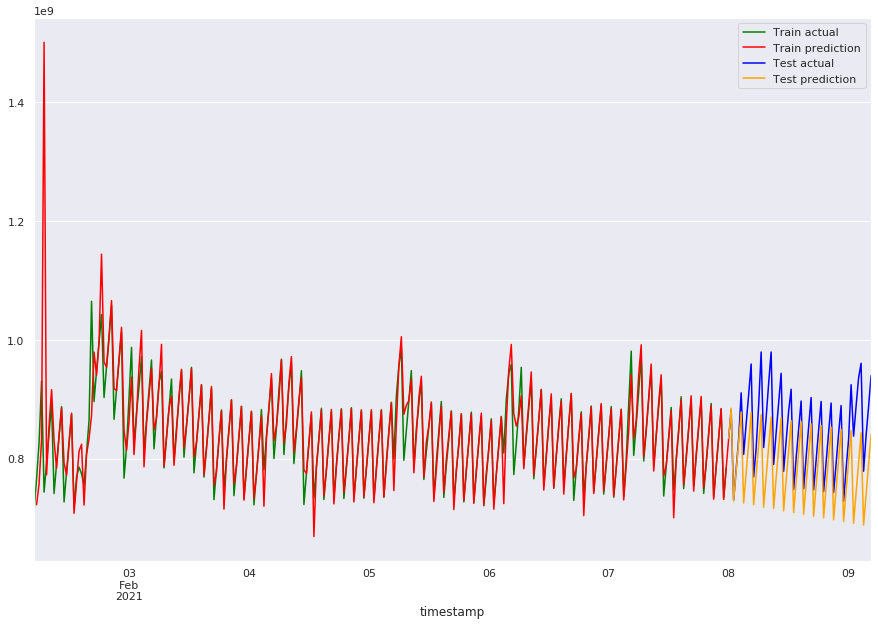

In [23]:
plot_predicts_man(pred_train_sarima_3133134, pred_sarima_3133134)

In [24]:
mae_train_sarima_3133134 = mean_absolute_error(
    pred_train_sarima_3133134, train
)
mae_sarima_3133134 = mean_absolute_error(pred_sarima_3133134, test)
print(
    f"train error: {mae_train_sarima_3133134}, test error: {mae_sarima_3133134}"
)

train error: 76039810.8512889, test error: 61440631.127542816


### [Fb Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
* Fb prophet is an open source forecasting tool developed by facebook. It's working is explained in this [paper](https://peerj.com/preprints/3190/).

In [25]:
## Convert data to prophet type
train_fb = (
    train.tz_localize(None)
    .reset_index()
    .rename(columns={"timestamp": "ds", "value": "y"})
)
test_fb = (
    test.tz_localize(None)
    .reset_index()
    .rename(columns={"timestamp": "ds", "value": "y"})
)
train_fb

,ds,y
0,2021-02-02 05:00:00,7.149560e+08
1,2021-02-02 05:30:00,7.661634e+08
2,2021-02-02 06:00:00,8.268711e+08
3,2021-02-02 06:30:00,9.307392e+08
4,2021-02-02 07:00:00,7.441884e+08
...,...,...
273,2021-02-07 21:30:00,7.860433e+08
274,2021-02-07 22:00:00,8.343954e+08
275,2021-02-07 22:30:00,8.838431e+08
276,2021-02-07 23:00:00,7.338868e+08


In [26]:
proph_model = Prophet()
pm = proph_model.fit(train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [27]:
future = pd.concat([train_fb[["ds"]], test_fb[["ds"]]])
forecast = proph_model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
331,2021-02-09 02:30:00,8.159005e+08,7.226906e+08,8.959902e+08
332,2021-02-09 03:00:00,8.249485e+08,7.356618e+08,9.102047e+08
333,2021-02-09 03:30:00,8.335671e+08,7.366603e+08,9.268038e+08
334,2021-02-09 04:00:00,8.408378e+08,7.512273e+08,9.263069e+08
335,2021-02-09 04:30:00,8.461327e+08,7.632898e+08,9.335285e+08


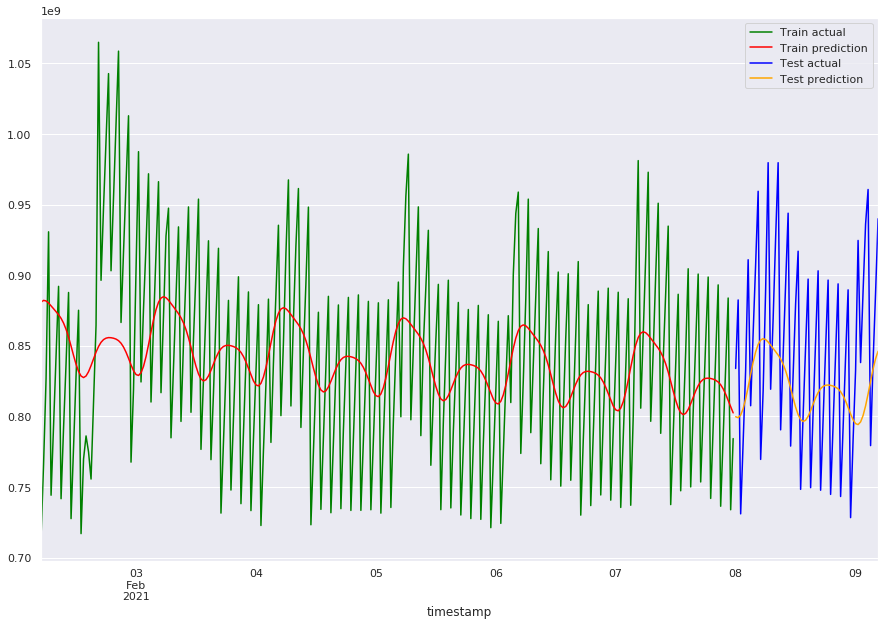

In [28]:
plot_predicts_aam(forecast["yhat"][:278].values, forecast["yhat"][278:].values)

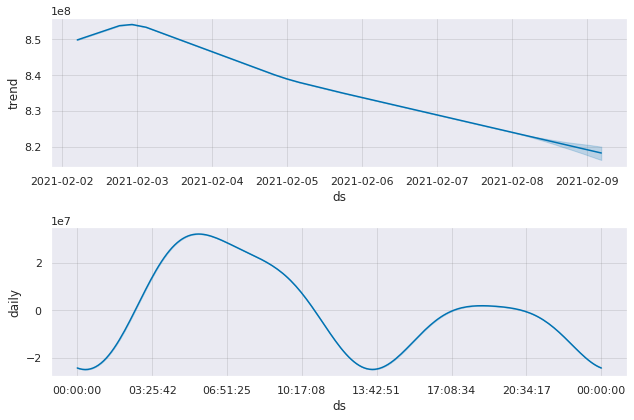

In [29]:
## Prophet finds components as well and forecasts the trend
fig2 = proph_model.plot_components(forecast)

In [30]:
mae_train_prophet = mean_absolute_error(forecast.yhat.iloc[:278], train)
mae_prophet = mean_absolute_error(forecast.yhat.iloc[278:], test)
print(f"train error: {mae_train_prophet}, test error: {mae_prophet}")

train error: 57397365.15948534, test error: 59003779.90772527


### Decomposition + trend prediction
* In this method we use the concept of seasonality decomposition. We remove the seasonal component and forecast the adjusted time series. Once we have the forecasted value, we add the seasonality back to the prediction. This method, like SARIMAX, assumes that we have some prior knowledge of the seasons in our time series.
* We use prophet for trend prediction, but any method can be used.

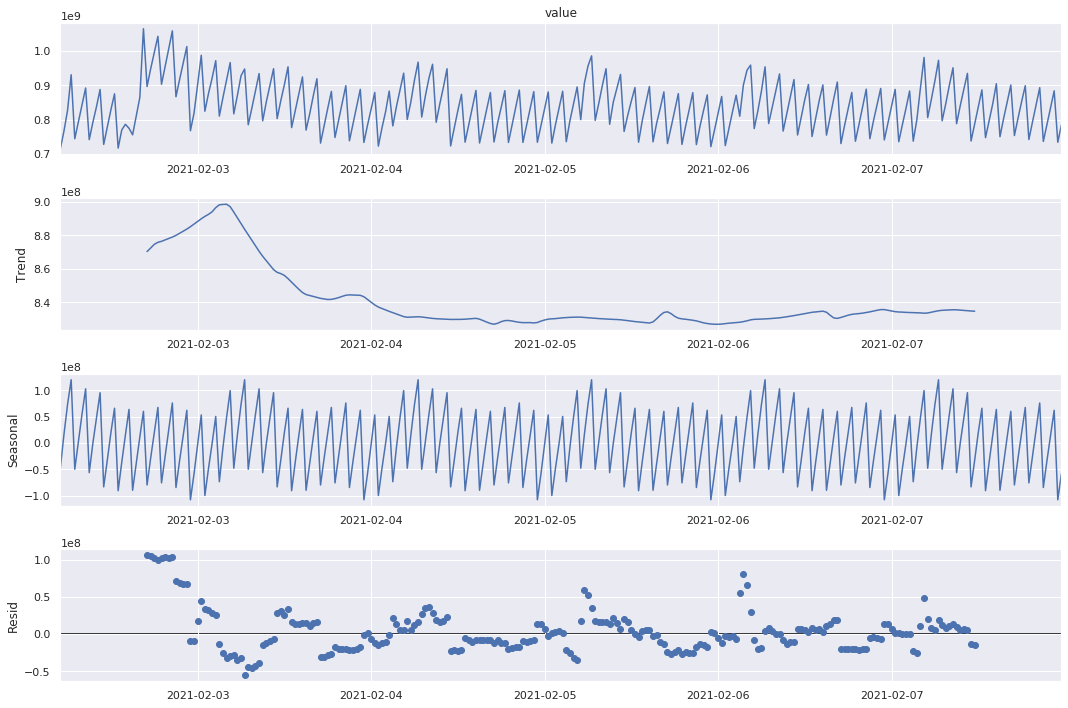

In [31]:
sns.set()
plt.rc("figure", figsize=(15, 10))
sd_add = seasonal_decompose(train, model="additive", freq=2 * 24)
sd_add.plot()
plt.show()

In [32]:
train_adj = train - sd_add.seasonal
train_adj_fb = (
    train_adj.tz_localize(None)
    .reset_index()
    .rename(columns={"timestamp": "ds", 0: "y"})
)
test_fb = (
    test.tz_localize(None)
    .reset_index()
    .rename(columns={"timestamp": "ds", 0: "y"})
)

In [33]:
# Here we take one period from the train decomposed set
# with similar start and end point as the test set
test_set_period_adj = sd_add.seasonal["2021-02-03":"2021-02-04 4:30"]

In [34]:
## Prophet model
proph_model = Prophet()
pm = proph_model.fit(train_adj_fb)
future = pd.concat([train_adj_fb[["ds"]], test_fb[["ds"]]])
forecast = proph_model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


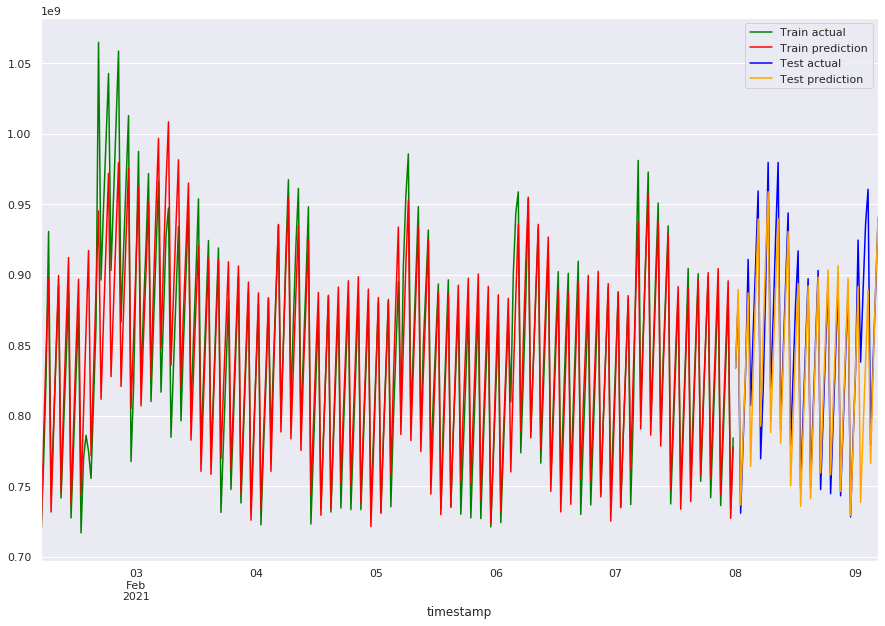

In [35]:
train_predict_fb_adj = forecast["yhat"][:278].values + sd_add.seasonal.values
predict_fb_adj = forecast["yhat"][278:].values + test_set_period_adj.values
plot_predicts_aam(train_predict_fb_adj, predict_fb_adj)

In [36]:
mae_train_fb_adj = mean_absolute_error(train_predict_fb_adj, train)
mae_fb_adj = mean_absolute_error(predict_fb_adj, test)
print(f"train error: {mae_train_fb_adj}, test error: {mae_fb_adj}")

train error: 18666697.80771729, test error: 20050884.18485607


### Next, we look at mean absolute errors for all the methods together

In [38]:
pd.DataFrame(
    data=[
        ["aam_default", mae_train_aam_default, mae_aam_default],
        ["aam_tuned", mae_train_aam_tuned, mae_aam_tuned],
        ["arima_312", mae_train_arima_312, mae_arima_312],
        ["ARIMA_313", mae_train_arima_313, mae_arima_313],
        ["sarima_3133134", mae_train_sarima_3133134, mae_sarima_3133134],
        ["prophet", mae_train_prophet, mae_prophet],
        ["decompose+ARIMA", mae_train_fb_adj, mae_fb_adj],
    ],
    columns=["Method", "Train error", "Test error"],
)

,Method,Train error,Test error
0,aam_default,5.970445e+07,5.549903e+07
1,aam_tuned,6.910468e+07,4.850166e+07
2,arima_312,8.398112e+08,8.473096e+08
3,ARIMA_313,8.399555e+08,8.465721e+08
4,sarima_3133134,7.603981e+07,6.144063e+07
5,prophet,5.739737e+07,5.900378e+07
6,decompose+ARIMA,1.866670e+07,2.005088e+07


## Conclusion

In this notebook, we saw some frequently explored ways to forecast a time series. In our example, the method with seasonal decomposition and trend prediction using fbprophet perfromed the best. The method of removing the seasonal effects and predicting the trend performs well if your data has obvious seasonality. Prophet is a powerful tool that works well with various types of time series and it's performance can be increased with using methods like decomposition. For a general dataset, similar experiments need to be conducted to choose a model. 


## References 
* https://machinelearningmastery.com/findings-comparing-classical-and-machine-learning-methods-for-time-series-forecasting/
* https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb
* https://otexts.com/fpp2/